In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import io
import os
from PIL import Image

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [17]:
import matplotlib.pyplot as plt

In [2]:
DATAPATH = 'images/'

In [58]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2))
    return img

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def show_image(a,save=False,save_fname=None):
    ''' display the image using matplotlib'''
    plt.figure(figsize=(8,6))
    a = np.uint8(np.clip(a, 0, 255))
    plt.imshow(a)
    plt.show()
    if save:
        if save_fname is None:
            raise ValueError('save_fname must be set if save=True')
        plt.imsave(save_fname,a)

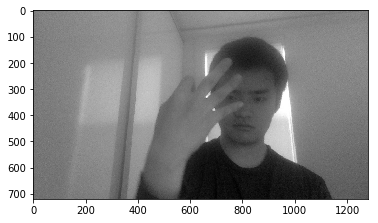

In [101]:
test = cv2.imread(DATAPATH + 'L/frame770.jpg')
test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
plt.imshow(test, cmap="gray")
plt.show()

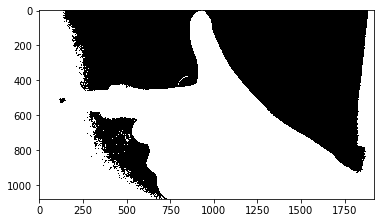

In [99]:
blur = cv2.GaussianBlur(test,(5,5),0)
ret, thresh1 = cv2.threshold(blur,70,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh1, cmap="gray")
plt.show()

In [100]:
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    cnt=contours[i]
    area = cv2.contourArea(cnt)
    if(area>max_area):
        max_area=area
        ci=i
    cnt=contours[ci]
hull = cv2.convexHull(cnt)
drawing = np.zeros(img.shape,np.uint8)
cv2.drawContours(drawing,[cnt],0,(0,255,0),2)
cv2.drawContours(drawing,[hull],0,(0,0,255),2)

ValueError: too many values to unpack (expected 2)

In [3]:
data = []
labels = []
label_index = 0 

for label in os.listdir(DATAPATH):
    if label == 'ok' or label == 'rock':
        img_dir = DATAPATH + label + '/'
        for fn in os.listdir(img_dir):
            img = cv2.imread(img_dir + fn, 1)
            img = preprocess(img)
            data.append(img)
            labels.append(label_index)
        label_index += 1    

print("Finished loading data")

Finished loading data


In [4]:
data = np.array(data)
labels = np.array(labels)

In [5]:
np.save('data3.npy', data)
np.save('labels3.npy', labels)

In [5]:
data = np.load('data2.npy')
labels = np.load('labels2.npy')

In [6]:
# data = data[:len(data)//4]
# labels = labels[:len(labels)//4]

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=6)

In [9]:
batch_size = 128
num_classes = 2
epochs = 12
channels = 3
# input image dimensions
img_rows, img_cols = int(720/4), int(1280/4)

# the data, split between train and test sets

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1600, 180, 320, 3)
1600 train samples
400 test samples


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1600 samples, validate on 400 samples
Epoch 1/12
1600/1600 [==============================] - 399s 250ms/step - loss: 6.7374 - acc: 0.5456 - val_loss: 8.7038 - val_acc: 0.4600
Epoch 2/12
1600/1600 [==============================] - 396s 247ms/step - loss: 7.8979 - acc: 0.5100 - val_loss: 8.7038 - val_acc: 0.4600
Epoch 3/12
1600/1600 [==============================] - 408s 255ms/step - loss: 7.8979 - acc: 0.5100 - val_loss: 8.7038 - val_acc: 0.4600
Epoch 4/12
 640/1600 [===========>..................] - ETA: 17:15 - loss: 7.9583 - acc: 0.5062

KeyboardInterrupt: 

In [ ]:
with open("results.txt", "w") as f:
    f.write(score)

In [ ]:
model.save("model_0.h5")